In [2]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [3]:
train_feats = pd.read_csv('../../kaggle feat_eng/silver_bullet_192feat.csv')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [4]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [26]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler(feature_range=(-1, 1))

        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_train = imputer.fit_transform(X_train)
        X_train = scaler.fit_transform(X_train)
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        X_valid = imputer.transform(X_valid)
        X_valid = scaler.transform(X_valid)

        model = SVR(kernel='rbf', C=1, epsilon=0.1)
        model.fit(X_train, y_train.values.ravel())
        valid_predict = model.predict(X_valid)

        OOF_SCORE[valid_idx] += valid_predict / iterations
        j+=1
        # models_dict[f'{fold}_{i}'] = model

In [27]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric LGBM = 0.62202


In [ ]:
import pickle

with open('base_lgb/OOF_base_lgb.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

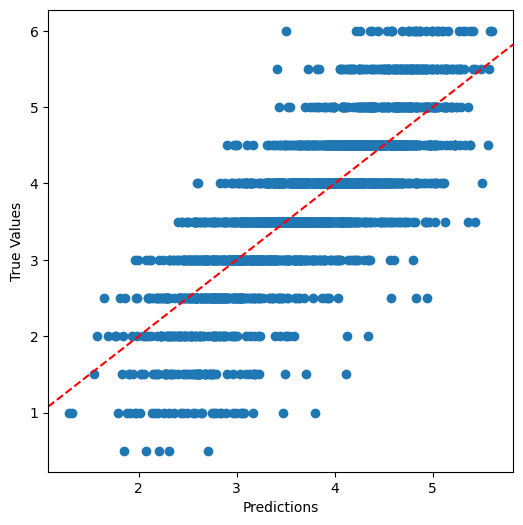

In [11]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()